# Optimisation of rocket gravity turn parameters

In [1]:
import sympy as sp
import scipy as scp
import scipy.constants as scpc
import numpy as np
import matplotlib.pyplot as plt

## Modelisation of the gravity turn

### Environment equations

#### U.S. Standard Atmosphere

In this work, we will be using the [U.S. Standard Atmosphere](http://www.braeunig.us/space/atmmodel.htm#table4)
equations for the pressure and temperature which are defined by the following table

| Geopotential Altitude $h$ [km] | Temperature [K] | Pressure $p_0$ [Pa] |
|-|-|-|
| 0-11 | $288.15 - 6.5h$ | $101325.0 × (\frac{288.15}{288.15 – 6.5h})^{\frac{34.1632}{–6.5}}$ |
| 11-20 | $216.65$ | $22632.06 × exp(\frac{–34.1632(h – 11)}{216.65})$ |
| 20-32 | $196.65 + h$ | $5474.889 × (\frac{216.65}{216.65 + (h – 20)})^{34.1632}$ |
| 32-47 | $139.05 + 2.8h$ | $868.0187 × (\frac{228.65}{228.65 + 2.8(h – 32)})^{\frac{34.1632}{2.8}}$ |
| 47-51 | $270.65$ | $110.9063 × exp(\frac{–34.1632(h – 47)}{270.65})$ |
| 51-71 | $413.45 – 2.8h$ | $66.93887 × (\frac{270.65}{270.65 – 2.8(h – 51)})^{\frac{34.1632}{–2.8}}$ |
| 71-86 | $356.65 – 2h$ | $3.956420 × (\frac{214.65}{214.65 – 2(h – 71)})^{\frac{34.1632}{–2}}$ |

**NOTE :** On a planet of radius $R_P$, the geopotential altitude $h$ is related to the altitude $z$ by the expression

In [2]:
t, R_P = sp.symbols('t R_P')
z = sp.Function('z')(t)
h = sp.Function('h')(z)
h_eq = sp.Eq(h, R_P*z/(R_P+z))
display(h_eq)

Eq(h(z(t)), R_P*z(t)/(R_P + z(t)))

#### Atmospheric pressure

In the rest of the modelisation, we will use the dummy function $P_{USSA}$ to represent the USSA's pressure equations

In [3]:
P = sp.Function('P')(z)
P_USSA = sp.Function('P_USSA')(h)
P_eq = sp.Eq(P, P_USSA)
display(P_eq)

Eq(P(z(t)), P_USSA(h(z(t))))

#### Atmospheric temperature

In the rest of the modelisation, we will use the dummy function $T_{USSA}$ to represent the USSA's temperature equations

In [4]:
T = sp.Function('T')(z)
T_USSA = sp.Function('T_USSA')(h)
T_eq = sp.Eq(T, T_USSA)
display(T_eq)

Eq(T(z(t)), T_USSA(h(z(t))))

#### Atmospheric density

The atmospheric density $\rho$ general equation reads

In [5]:
R, M_atm= sp.symbols('R M_atm')
rho = sp.Function('rho')(z)
rho_eq = sp.Eq(rho, P*M_atm/(R*T))
display(rho_eq)

Eq(rho(z(t)), M_atm*P(z(t))/(R*T(z(t))))

with $R$ the molar gas constant, $M_{atm}$ the molar mass of the atmosphere and $T$ the temperature.

### Rocket's equations

#### Mass equations

The rocket's mass $m$ is defined by

In [6]:
m_d = sp.symbols('m_D')
m = sp.Function('m')(t)
m_lf = sp.Function('m_LF')(t)
m_sf = sp.Function('m_SF')(t)
m_ox = sp.Function('m_Ox')(t)
m_eq = sp.Eq(m, m_d + m_lf + m_sf + m_ox)
display(m_eq)

Eq(m(t), m_D + m_LF(t) + m_Ox(t) + m_SF(t))

with $m_D$ the dry mass of the rocket, $m_{LF}$ the liquid fuel mass, $m_{SF}$ the solid fuel mass and $m_{Ox}$ the
oxidizer mass.

The evolution rate of the rocket's mass is defined by the mass derivative which, in absence of staging sequence, is
described by

In [7]:
q_lf, q_sf, q_ox, rho_lf, rho_sf, rho_ox = sp.symbols('Q_LF Q_SF Q_Ox rho_LF rho_SF rho_Ox')
dmdt_eq = sp.Eq(sp.Derivative(m,t), q_lf*rho_lf + q_sf*rho_sf + q_ox*rho_ox)
dm_lfdt_eq = sp.Eq(sp.Derivative(m_lf,t), q_lf*rho_lf)
dm_sfdt_eq = sp.Eq(sp.Derivative(m_sf,t), q_sf*rho_sf)
dm_oxdt_eq = sp.Eq(sp.Derivative(m_ox,t), q_ox*rho_ox)
display(dmdt_eq)
display(dm_lfdt_eq)
display(dm_sfdt_eq)
display(dm_oxdt_eq)

Eq(Derivative(m(t), t), Q_LF*rho_LF + Q_Ox*rho_Ox + Q_SF*rho_SF)

Eq(Derivative(m_LF(t), t), Q_LF*rho_LF)

Eq(Derivative(m_SF(t), t), Q_SF*rho_SF)

Eq(Derivative(m_Ox(t), t), Q_Ox*rho_Ox)

with $(Q_{LF},\rho_{LF})$, $(Q_{SF},\rho_{SF})$ and $(Q_{Ox},\rho_{Ox})$ the flow rates and volumetric masses of
respectively the liquid fuel, solid fuel and oxidizer.

#### Thrust equation

For a rocket engine (i.e. without air intake) of thrust $F_T$, the general thrust equation reads

In [8]:
v_e, P_e, A_e = sp.symbols('v_e P_e A_e')
F_T_norm = sp.Function('F_T')(t)
F_T_norm_eq = sp.Eq(F_T_norm, v_e*sp.Derivative(m,t) + (P_e-P)*A_e)
display(F_T_norm_eq)

Eq(F_T(t), A_e*(P_e - P(z(t))) + v_e*Derivative(m(t), t))

with $A_e$ the exit area, $P_e$ the exit pressure, $P$ the free stream pressure (or atmospheric pressure), $z$ the
altitude and $v_e$ the exit velocity.

We can replace the mass flow rate by its definition which yields

In [9]:
F_T_norm_eq = F_T_norm_eq.subs(dmdt_eq.lhs, dmdt_eq.rhs)
display(F_T_norm_eq)

Eq(F_T(t), A_e*(P_e - P(z(t))) + v_e*(Q_LF*rho_LF + Q_Ox*rho_Ox + Q_SF*rho_SF))

#### Drag equation

The basic drag model equation for subsonic non-turbulent flight reads

In [10]:
C_D, A_D = sp.symbols('C_D A_D')
F_D_norm = sp.Function('F_D')(t)
v = sp.Function('\overrightarrow{v}')(t)
F_D_norm_eq = sp.Eq(F_D_norm, (1/2)*rho*A_D*C_D*sp.Abs(v)**2)
display(F_D_norm_eq)

Eq(F_D(t), 0.5*A_D*C_D*rho(z(t))*Abs(\overrightarrow{v}(t))**2)

with $A_D$ the cross-section area exposed to the air stream, $C_D$ the coefficient of drag and $\overrightarrow{v}$ the
velocity vector.

As turbulent and supersonic drag are fairly complicated to model, the approach we might use is the one used by Kerbal
Space Program which uses two functions to apply a corrective factor as a function of the pseudo-Reynolds number $\rho
|\overrightarrow{v}|$ and the mach number
$$F_D = -\frac{1}{2} \rho A_D C_D|\overrightarrow{v}|\overrightarrow{v}f_{supersonic}(mach) f_{turbulent}(\rho|\overrightarrow{v}|)$$

### Motion's equations

In order to model the rocket's trajectory around a planet of mass $M_P$ and radius $R_P$, we will integrate along
time the acceleration $\frac{d^2\overrightarrow{p}}{dt^2}$ of the rocket which will be computed using the FPD
$$m\frac{d^2\overrightarrow{p}}{dt^2} = \sum{\overrightarrow{F}}. \qquad \text{(1)}$$
For simplicity's sake, we will be looking at Eq.1 in the polar referential
$(\overrightarrow{e_r},\overrightarrow{e_{\theta}})$.
In this referential, a point is defined by his coordinates $(r,\theta)$.

Subsequently, the position vector is defined by

In [11]:
r = sp.Function('r')(t)
e_r = sp.Function('\overrightarrow{e_r}')(t)
p = sp.Function('\overrightarrow{p}')(t)
p_eq = sp.Eq(p, r*e_r)
display(p_eq)

Eq(\overrightarrow{p}(t), \overrightarrow{e_r}(t)*r(t))

The velocity and acceleration vector are defined respectively by the first and second order derivative of
$\overrightarrow{p}$ with respect to time.

As a reminder, the derivatives of the base vectors $(\overrightarrow{e_r},\overrightarrow{e_{\theta}})$ are

In [12]:
theta = sp.Function('theta')(t)
e_theta = sp.Function('\overrightarrow{e_{\\theta}}')(t)
de_rdt_eq = sp.Eq(sp.Derivative(e_r, t), sp.Derivative(theta, t)*e_theta)
de_thetadt_eq = sp.Eq(sp.Derivative(e_theta, t), -sp.Derivative(theta, t)*e_r)
display(de_rdt_eq, de_thetadt_eq)

Eq(Derivative(\overrightarrow{e_r}(t), t), \overrightarrow{e_{\theta}}(t)*Derivative(theta(t), t))

Eq(Derivative(\overrightarrow{e_{\theta}}(t), t), -\overrightarrow{e_r}(t)*Derivative(theta(t), t))

Thus, the velocity vector is given by

In [13]:
v_eq = sp.Eq(v, sp.Derivative(p_eq.rhs, t)).doit().subs(de_rdt_eq.lhs, de_rdt_eq.rhs)
display(v_eq)

Eq(\overrightarrow{v}(t), \overrightarrow{e_r}(t)*Derivative(r(t), t) + \overrightarrow{e_{\theta}}(t)*r(t)*Derivative(theta(t), t))

which can simply be written $\overrightarrow{v} = v_r \overrightarrow{e_r} + v_{\theta} \overrightarrow{e_{\theta}}$.

The acceleration vector is given by

In [14]:
a = sp.Function('\overrightarrow{a}')(t)
a_eq = sp.Eq(a, sp.Derivative(v_eq.rhs, t)).doit().subs(de_rdt_eq.lhs, de_rdt_eq.rhs).subs(de_thetadt_eq.lhs, de_thetadt_eq.rhs)
display(a_eq)

Eq(\overrightarrow{a}(t), -\overrightarrow{e_r}(t)*r(t)*Derivative(theta(t), t)**2 + \overrightarrow{e_r}(t)*Derivative(r(t), (t, 2)) + \overrightarrow{e_{\theta}}(t)*r(t)*Derivative(theta(t), (t, 2)) + 2*\overrightarrow{e_{\theta}}(t)*Derivative(r(t), t)*Derivative(theta(t), t))

A rocket in flight is subject to multiple forces whose modeling will be detailed in the next sections.

#### Gravity

The force of gravity exerted by the planet on the rocket is described by

In [15]:
F_G_norm = sp.Function('F_G')(t)
F_G = sp.Function('\overrightarrow{F_G}')(t)
F_G_eq = sp.Eq(F_G, -F_G_norm*e_r)
display(F_G_eq)

Eq(\overrightarrow{F_G}(t), -F_G(t)*\overrightarrow{e_r}(t))

with

In [16]:
G, M_P = sp.symbols('G M_P')
F_G_norm_eq = sp.Eq(F_G_norm, G*M_P*m/r**2)
display(F_G_norm_eq)

Eq(F_G(t), G*M_P*m(t)/r(t)**2)

with $G$ the universal gravitational constant and $M_P$ the mass of the planet.

#### Thrust

We define the thrust vector of the rocket as $\overrightarrow{F_T}$ and the thrust vector norm as
$|\overrightarrow{F_T}|=F_T$. Depending of the pitch of the rocket $\alpha_T$, the radial and tangential components vary during the
flight yielding

In [17]:
F_T = sp.Function('\overrightarrow{F_T}')(t)
alpha_T = sp.Function('alpha_T')(t)
F_T_eq = sp.Eq(F_T, F_T_norm*(sp.sin(alpha_T)*e_r + sp.cos(alpha_T)*e_theta))
display(F_T_eq)

Eq(\overrightarrow{F_T}(t), (\overrightarrow{e_r}(t)*sin(alpha_T(t)) + \overrightarrow{e_{\theta}}(t)*cos(alpha_T(t)))*F_T(t))

However, while performing the gravity turn, the thrust should always be colinear with the velocity vector
$\overrightarrow{v}$ which yields 

In [18]:
v_r = sp.Function('v_r')(t)
v_theta = sp.Function('v_{\\theta}')(t)
alpha_T_eq = sp.Eq(alpha_T, sp.atan(v_r/v_theta))
display(alpha_T_eq)

Eq(alpha_T(t), atan(v_r(t)/v_{\theta}(t)))

#### Drag

The drag equation previously defined projected in the base vectors yields

In [19]:
F_D = sp.Function('\overrightarrow{F_D}')(t)
F_D_eq = sp.Eq(F_D, -F_D_norm*(v_r/sp.Abs(v)*e_r + v_theta/sp.Abs(v)*e_theta))
display(F_D_eq)

Eq(\overrightarrow{F_D}(t), -(\overrightarrow{e_r}(t)*v_r(t)/Abs(\overrightarrow{v}(t)) + \overrightarrow{e_{\theta}}(t)*v_{\theta}(t)/Abs(\overrightarrow{v}(t)))*F_D(t))

#### Equations of motion in polar referential

Summing all forces on the right hand side of Eq.1 yields

In [20]:
FPD_eq = sp.Eq(m*a_eq.lhs, F_G_eq.lhs + F_T_eq.lhs + F_D_eq.lhs)
display(FPD_eq)

Eq(\overrightarrow{a}(t)*m(t), \overrightarrow{F_D}(t) + \overrightarrow{F_G}(t) + \overrightarrow{F_T}(t))

Once expanded, we get the following

In [21]:
FPD_eq = FPD_eq.subs(a_eq.lhs, a_eq.rhs)
display(FPD_eq)

Eq((-\overrightarrow{e_r}(t)*r(t)*Derivative(theta(t), t)**2 + \overrightarrow{e_r}(t)*Derivative(r(t), (t, 2)) + \overrightarrow{e_{\theta}}(t)*r(t)*Derivative(theta(t), (t, 2)) + 2*\overrightarrow{e_{\theta}}(t)*Derivative(r(t), t)*Derivative(theta(t), t))*m(t), \overrightarrow{F_D}(t) + \overrightarrow{F_G}(t) + \overrightarrow{F_T}(t))

Projecting the previous equation on the base vectors and solving for $\frac{d^2r}{dt^2}$ and $\frac{d^2\theta}{dt^2}$ yields

In [22]:
FPD_eq = FPD_eq.subs(F_G_eq.lhs, F_G_eq.rhs).subs(F_T_eq.lhs, F_T_eq.rhs).subs(F_D_eq.lhs, F_D_eq.rhs)
FPD_e_r_eq = FPD_eq.subs(e_r, 1).subs(e_theta, 0)
FPD_e_theta_eq = FPD_eq.subs(e_r, 0).subs(e_theta, 1)

d2rdt2_eq = sp.Eq(sp.Derivative(r, t, 2), sp.solve(FPD_e_r_eq, sp.Derivative(r, t, 2))[0]).expand()
d2thetadt2_eq = sp.Eq(sp.Derivative(theta, t, 2), sp.solve(FPD_e_theta_eq, sp.Derivative(theta, t, 2))[0]).expand()
display(d2rdt2_eq, d2thetadt2_eq)

Eq(Derivative(r(t), (t, 2)), -F_D(t)*v_r(t)/(m(t)*Abs(\overrightarrow{v}(t))) - F_G(t)/m(t) + F_T(t)*sin(alpha_T(t))/m(t) + r(t)*Derivative(theta(t), t)**2)

Eq(Derivative(theta(t), (t, 2)), -F_D(t)*v_{\theta}(t)/(m(t)*r(t)*Abs(\overrightarrow{v}(t))) + F_T(t)*cos(alpha_T(t))/(m(t)*r(t)) - 2*Derivative(r(t), t)*Derivative(theta(t), t)/r(t))

### First order ODE system

In order to use `scipy.integrate`, we need to write the equations of motion as a first order ODE system using the state
vector $\overrightarrow{X} = (r,\theta,v_r,\omega)$, i.e. find $f(\overrightarrow{X})$ so that
$\frac{d\overrightarrow{X}}{dt} = f(\overrightarrow{X})$.

In [23]:
omega = sp.Function('omega')(t)
v_norm = sp.Function('v')(t)
ODE_system = [sp.Eq(sp.Derivative(r,t), v_r),
              sp.Eq(sp.Derivative(theta,t), omega),
              d2rdt2_eq.subs(sp.Derivative(r,t), v_r).subs(sp.Derivative(theta,t), omega),
              d2thetadt2_eq.subs(sp.Derivative(r,t), v_r).subs(sp.Derivative(theta,t), omega)]

ODE_system[2] = ODE_system[2].subs(sp.Abs(v), v_norm)
ODE_system[2] = ODE_system[2].subs(v_theta, r*omega)

ODE_system[3] = ODE_system[3].subs(sp.Abs(v), v_norm)
ODE_system[3] = ODE_system[3].subs(v_theta, r*omega)

for eq in ODE_system:
    display(eq)

Eq(Derivative(r(t), t), v_r(t))

Eq(Derivative(theta(t), t), omega(t))

Eq(Derivative(v_r(t), t), -F_D(t)*v_r(t)/(m(t)*v(t)) - F_G(t)/m(t) + F_T(t)*sin(alpha_T(t))/m(t) + omega(t)**2*r(t))

Eq(Derivative(omega(t), t), -F_D(t)*omega(t)/(m(t)*v(t)) + F_T(t)*cos(alpha_T(t))/(m(t)*r(t)) - 2*omega(t)*v_r(t)/r(t))

#### Codegen

In [24]:
ode_system_function = 'def ode_system(t, x, planet, rocket):\n    dfdx=np.zeros(len(x))\n    r, theta, v_r, omega = x\n    v = np.sqrt(omega**2*r**2 + v_r**2)\n    if v==0: v = 1e-6'
i=0
replace_pairs = [('m(t)','rocket.m(t)'),
                 ('F_G(t)','rocket.F_G(t, r, planet.M)'),
                 ('F_D(t)','rocket.F_D(planet.rho(r), v)'),
                 ('F_T(t)','rocket.F_T(t, planet.P(r))'),
                 ('alpha_T(t)', 'rocket.pitch(t, x)'),
                 ('v(t)','v'),
                 ('r(t)','r'),
                 ('v_r(t)','v_r'),
                 ('omega(t)','omega'),
                 ('math.','np.')]
for eq in ODE_system:
    code = sp.pycode(eq.rhs)
    lines = code.splitlines()
    for line in lines:
        if '#' not in line:
            for pair in replace_pairs:
                line = line.replace(pair[0],pair[1])
            ode_system_function += '\n    ' + 'dfdx[' + str(i) + '] = ' + line
    i += 1
ode_system_function += '\n    return dfdx'

print(ode_system_function)
exec(ode_system_function)

def ode_system(t, x, planet, rocket):
    dfdx=np.zeros(len(x))
    r, theta, v_r, omega = x
    v = np.sqrt(omega**2*r**2 + v_r**2)
    if v==0: v = 1e-6
    dfdx[0] = v_r
    dfdx[1] = omega
    dfdx[2] = -rocket.F_D(planet.rho(r), v)*v_r/(rocket.m(t)*v) - rocket.F_G(t, r, planet.M)/rocket.m(t) + rocket.F_T(t, planet.P(r))*np.sin(rocket.pitch(t, x))/rocket.m(t) + omega**2*r
    dfdx[3] = -rocket.F_D(planet.rho(r), v)*omega/(rocket.m(t)*v) + rocket.F_T(t, planet.P(r))*np.cos(rocket.pitch(t, x))/(rocket.m(t)*r) - 2*omega*v_r/r
    return dfdx


### Orbit parameters

#### Periapsis and apoapsis

In order to know the cutoff time and the circularization burn time, we need to compute the orbits parameters (i.e.
apoapsis, periapsis, time to apoapsis and periapsis ...)

This is done using the orbit energy equation which reads

In [25]:
mu = sp.symbols('mu')
E_orb = sp.Function('E_orb')(t)
E_orb_eq = sp.Eq(E_orb, v_norm**2/2 - mu/r)
display(E_orb_eq)

Eq(E_orb(t), -mu/r(t) + v(t)**2/2)

with $\mu = GM_P$.

From the orbital energy we get the semi-major axis $a$ of the orbit with

In [26]:
a = sp.Function('a')(t)
a_eq = sp.Eq(a, -mu/(2*E_orb))
display(a_eq)

Eq(a(t), -mu/(2*E_orb(t)))

We also get the eccentricity vector $\overrightarrow{e}$ of the orbit with

In [27]:
e = sp.Function('\overrightarrow{e}')(t)
e_eq = sp.Eq(e, e_r*(r*v_norm**2/mu - 1) - v*r*v_r/mu).subs(v, v_r*e_r + v_theta*e_theta).subs(v_norm**2, v_r**2 + v_theta**2).subs(v_theta, r*omega).expand()
e_eq = sp.Eq(e, e_eq.rhs.collect(e_r))
display(e_eq)

Eq(\overrightarrow{e}(t), (-1 + omega(t)**2*r(t)**3/mu)*\overrightarrow{e_r}(t) - \overrightarrow{e_{\theta}}(t)*omega(t)*r(t)**2*v_r(t)/mu)

For simplicity, let's compute the norm of $\overrightarrow{e}$

In [28]:
e_norm = sp.Function('e')(t)
e_norm_eq = sp.Eq(e_norm, sp.sqrt(e_eq.rhs.coeff(e_r)**2 + e_eq.rhs.coeff(e_theta)**2))
display(e_norm_eq)

Eq(e(t), sqrt((-1 + omega(t)**2*r(t)**3/mu)**2 + omega(t)**2*r(t)**4*v_r(t)**2/mu**2))

The periapsis $r_p$ and apoapsis $r_a$ are then computed with

In [29]:
r_p = sp.Function('r_p')(t)
r_a = sp.Function('r_a')(t)
r_p_eq = sp.Eq(r_p, a*(1-e_norm))
r_a_eq = sp.Eq(r_a, a*(1+e_norm))
display(r_p_eq, r_a_eq)

Eq(r_p(t), (1 - e(t))*a(t))

Eq(r_a(t), (e(t) + 1)*a(t))

#### Time to apoapsis

In order to find the time to apoapsis, we first compute the true anomaly $\nu$

In [30]:
nu = sp.Function('nu')(t)
nu_eq = sp.Eq(nu, sp.acos(e*e_r/e_norm))
display(nu_eq)

Eq(nu(t), acos(\overrightarrow{e_r}(t)*\overrightarrow{e}(t)/e(t)))

From the true anomaly, the eccentric anomaly $E$ reads

In [31]:
E = sp.Function('E')(t)
E_eq = sp.Eq(E, 2*sp.atan(sp.tan(nu/2)*sp.sqrt((1-e_norm)/(1+e_norm))))
display(E_eq)

Eq(E(t), 2*atan(sqrt((1 - e(t))/(e(t) + 1))*tan(nu(t)/2)))

And the mean anomaly $M$ reads

In [32]:
M = sp.Function('M')(t)
M_eq = sp.Eq(M, E-e_norm*sp.sin(E))
display(M_eq)

Eq(M(t), E(t) - e(t)*sin(E(t)))

Finally we can express the time to apoapsis as a function of the mean anomaly which yields

In [33]:
dt_ap = sp.Function('\Delta t_ap')(t)
dt_ap_eq = sp.Eq(dt_ap, (sp.pi-M)/sp.sqrt(G*M_P/a**3))
display(dt_ap_eq)

Eq(\Delta t_ap(t), (pi - M(t))/sqrt(G*M_P/a(t)**3))

#### Circularization burn time

First we need to compute the velocity at the apoapsis. Using the definition of the specific orbital energy (which
remains constant along a given orbit) we get

In [34]:
v_r_a = sp.Function('v_ra')(t)
v_r_a_eq = E_orb_eq.subs(v_norm, v_r_a).subs(r, r_a)
v_r_a_eq = sp.Eq(v_r_a, sp.solve(v_r_a_eq, v_r_a)[1])
display(v_r_a_eq)

Eq(v_ra(t), sqrt(2*mu/r_a(t) + 2*E_orb(t)))

Then we compute the velocity needed to for a circular orbit of radius $r_a$ which reads

In [35]:
v_orb = sp.Function('v_orb')(r_a)
v_orb_eq = sp.Eq(v_orb, sp.sqrt(mu/r_a))
display(v_orb_eq)

Eq(v_orb(r_a(t)), sqrt(mu/r_a(t)))

Then the $\Delta v$ needed to perform the circularization simply reads

In [36]:
dv_circ = sp.Function('\\Delta v_circ')(r_a)
dv_circ_eq = sp.Eq(dv_circ, v_orb-v_r_a)
display(dv_circ_eq)

Eq(\Delta v_circ(r_a(t)), v_orb(r_a(t)) - v_ra(t))

Now in order to find the burn time, we first need to use the Tsiolkovsky equation to find the mass difference $\Delta m$
which yields (for a constant thrust and mass derivative)

In [37]:
dv = sp.Symbol('\\Delta v')
dm = sp.Symbol('\\Delta m')
m_i, m_f = sp.symbols('m_i m_f')
dv_eq = sp.Eq(dv, F_T_norm*sp.ln(m_i/m_f)/sp.Derivative(m,t))
display(dv_eq)
m_f_eq = sp.Eq(m_f, sp.solve(dv_eq, m_f)[0])
display(m_f_eq)
dm_eq = sp.Eq(dm, (m_i - m_f_eq.rhs).collect(m_i))
display(dm_eq)

Eq(\Delta v, F_T(t)*log(m_i/m_f)/Derivative(m(t), t))

Eq(m_f, m_i*exp(-\Delta v*Derivative(m(t), t)/F_T(t)))

Eq(\Delta m, m_i*(1 - exp(-\Delta v*Derivative(m(t), t)/F_T(t))))

Finally we compute the burn time using the mass derivative equation

In [38]:
dt_burn = sp.Symbol('\\Delta t_burn')
dmdt_eq = dmdt_eq.subs(sp.Derivative(m,t), dm/dt_burn)
display(dmdt_eq)
dt_burn_eq = sp.Eq(dt_burn, sp.solve(dmdt_eq,dt_burn)[0])
display(dt_burn_eq)

Eq(\Delta m/\Delta t_burn, Q_LF*rho_LF + Q_Ox*rho_Ox + Q_SF*rho_SF)

Eq(\Delta t_burn, \Delta m/(Q_LF*rho_LF + Q_Ox*rho_Ox + Q_SF*rho_SF))

## Simulation of the gravity turn

### Definition of the `Atmosphere` and `Planet` objects

In [39]:
class Atmosphere(object):
    def __init__(self, M, R=8.314462618) -> None:
        self.M = M
        self.R = R

    def P(self, z:float) -> float:
        raise NotImplementedError

    def T(self, z:float) -> float:
        raise NotImplementedError
    
    def rho(self, z:float) -> float:
        return self.M*self.P(z)/(self.R*self.T(z))

class USSA(Atmosphere):
    def __init__(self, M=28.964917e-3, R_P=6378.137e3) -> None:
        super().__init__(M)
        self.R_P = R_P
        
    def P(self, z:float) -> float:
        h = self.h(z)*1e-3
        if h<11: return 101325*np.power(288.15/(288.15-6.5*h), 34.1632/-6.5)
        elif h<20: return 22632.06*np.exp(-34.1632*(h-11)/216.65)
        elif h<32: return 5474.889*np.power(216.65/(216.65+(h-20)), 34.1632)
        elif h<47: return 868.0187*np.power(228.65/(228.65+2.8*(h-32)), 34.1632/2.8)
        elif h<51: return 110.9063*np.exp(-34.1632*(h-47)/270.65)
        elif h<71: return 66.93887*np.power(270.65/(270.65-2.8*(h-51)), 34.1632/-2.8)
        elif h<86: return 3.956420*np.power(214.65/(214.65-2*(h-71)), 34.1632/-2)
        else: return 0
        
    def T(self, z:float) -> float:
        h = self.h(z)*1e-3
        if h<11: return 288.15-6.5*h
        elif h<20: return 216.65
        elif h<32: return 196.65+h
        elif h<47: return 139.05+2.8*h
        elif h<51: return 270.65
        elif h<71: return 413.45-2.8*h
        elif h<86: return 356.65-2*h
        else: return 184.65
        
    def h(self, z:float) -> float:
        return self.R_P*z/(self.R_P+z)

class Planet(object):
    def __init__(self, M=5.972168e24, R=6378.137e3, atm=USSA()) -> None:
        self.M = M
        self.R = R
        self.atm = atm
    
    def P(self, r:float) -> float:
        return self.atm.P(r-self.R)
    
    def T(self, r:float) -> float:
        return self.atm.T(r-self.R)
    
    def rho(self, r:float) -> float:
        return self.atm.rho(r-self.R)

In [40]:
earth = Planet()

### Definition of the `Maneuver` and `FlightComputer` objects

In [41]:
class Maneuver(object):
    def __init__(self, label:str) -> None:
        self.label = label
    
    def pitch(self, t, x):
        raise NotImplementedError
    
class FlightComputer(object):
    def __init__(self, flight_plan:list[Maneuver]) -> None:
        self.flight_plan = flight_plan
    
    def next_maneuver(self):
        self.flight_plan.pop(0)
    
    def pitch(self, t, x):
        return self.flight_plan[0].pitch(t, x)

### Definition of the `Engine` object

In [42]:
class Engine(object):
    def __init__(self, A_e, P_e, v_e, Q_LF, rho_LF, Q_Ox, rho_Ox, Q_SF, rho_SF) -> None:
        self.A_e = A_e
        self.P_e = P_e
        self.v_e = v_e
        self.Q_LF = Q_LF
        self.rho_LF = rho_LF
        self.Q_Ox = Q_Ox
        self.rho_Ox = rho_Ox
        self.Q_SF = Q_SF      
        self.rho_SF = rho_SF
    
    def F_T(self, P0):
        return self.A_e*(self.P_e-P0) + self.v_e*(self.rho_LF*self.Q_LF + self.rho_Ox*self.Q_Ox + self.rho_SF*self.Q_SF)

### Definition of the `Stage` and `Fairing` objects

In [43]:
class Stage(object):
    def __init__(self, engines:list[Engine], m_D, m_LF, m_Ox, m_SF, A_D=None, C_D=None) -> None:
        self.engines = engines
        self.m_D = m_D
        self.m_LF = m_LF
        self.m_Ox = m_Ox
        self.m_SF = m_SF
        self.A_D = A_D
        self.C_D = C_D

        self.t_i = None
        self.Q_LF = 0
        self.rho_LF = engines[0].rho_LF
        self.Q_Ox = 0
        self.rho_Ox = engines[0].rho_Ox
        self.Q_SF = 0
        self.rho_SF = engines[0].rho_SF
        for engine in self.engines:
            self.Q_LF += engine.Q_LF
            self.Q_Ox += engine.Q_Ox
            self.Q_SF += engine.Q_SF
        if self.m_SF == 0:
            self.t_burn = min(m_LF/(self.Q_LF*self.rho_LF), m_Ox/(self.Q_Ox*self.rho_Ox))
        else:
            self.t_burn = m_SF/(self.Q_SF*self.rho_SF)
    
    def ignite(self, t_i):
        self.t_i = t_i
    
    def cutoff(self, t_co):
        self.t_burn -= (t_co - self.t_i)
        self.m_LF -= (t_co - self.t_i)*self.Q_LF*self.rho_LF
        self.m_Ox -= (t_co - self.t_i)*self.Q_Ox*self.rho_Ox
        self.m_SF -= (t_co - self.t_i)*self.Q_SF*self.rho_SF
        self.t_i = None
    
    def m(self, t):
        if self.t_i is None:
            return self.m_D + self.m_LF + self.m_Ox + self.m_SF
        else:
            return self.m_D + self.m_LF + self.m_Ox + self.m_SF - min(self.t_burn, max(0, t-self.t_i))*(self.Q_LF*self.rho_LF + self.Q_Ox*self.rho_Ox + self.Q_SF*self.rho_SF)
    
    def F_T(self, t, P0):
        F_T = 0
        if (self.t_i is not None and t<self.t_i + self.t_burn) or t==-1:
            for engine in self.engines:
                F_T += engine.F_T(P0)
        return F_T
    
    def F_D(self, rho, v):
        if self.A_D is None or self.C_D is None:
            return 0
        else:
            return 0.5*self.A_D*self.C_D*rho*v**2

class Fairing(Stage):
    def __init__(self, m:float, A_D:float, C_D:float, engines=[], m_LF=0, m_Ox=0, m_SF=0) -> None:
        super().__init__(engines, m, m_LF, m_Ox, m_SF, A_D=A_D, C_D=C_D)
    
    def m(self, t):
        return self.m_D

    def F_D(self, rho, v):
            return 0.5*self.A_D*self.C_D*rho*v**2 # type: ignore

### Definition of the `Payload` object

In [44]:
class Payload(object):
    def __init__(self, m) -> None:
        self.m = m

### Definition of the `Rocket` object

In [45]:
class Rocket(object):
    def __init__(self, stages:list, payload:Payload, FC:FlightComputer) -> None:
        self.stages = stages
        self.active_stages = []
        self.payload = payload
        self.FC = FC
    
    def pitch(self, t, x):
        return self.FC.pitch(t, x)

    def activate(self, n=0):
        self.active_stages.append(self.stages.pop(n))
        
    def ignite(self, t_i, n_i=-1):
        self.active_stages[n_i].ignite(t_i)

    def cutoff(self, t_co, n_co=0):
        self.active_stages[n_co].cutoff(t_co)
    
    def decouple(self, n_d=0):
        self.active_stages.pop(n_d)

    def stage(self, t, n=0, n_d=0):
        self.cutoff(t, n_co=n_d)
        self.decouple(n_d=n_d)
        self.activate(n)
        self.ignite(t)
    
    def m(self, t:float) -> float:
        m = self.payload.m
        for stage in self.stages:
            m += stage.m(t)
        for stage in self.active_stages:
            m += stage.m(t)
        return m
    
    def dmdt(self) -> float:
        dmdt=0
        for stage in self.active_stages:
            dmdt += stage.Q_LF*stage.rho_LF + stage.Q_Ox*stage.rho_Ox + stage.Q_SF*stage.rho_SF
        return dmdt
    
    def F_G(self, t:float, r:float, M_P:float) -> float:
        return scpc.G*M_P*self.m(t)/r**2
    
    def F_T(self, t, P0):
        F_T = 0
        for stage in self.active_stages:
            F_T += stage.F_T(t, P0)
        return F_T

    def F_D(self, rho, v):
        F_D = 0
        for stage in self.stages:
            F_D += stage.F_D(rho, v)
        return F_D

### Definition of the `r_a`, `r_p`, `t2r_a` and `dt_burn` functions

In [46]:
def r_p(x, planet):
    r, theta, v_r, omega = x
    v = np.sqrt(v_r**2 + (r*omega)**2)
    mu = scpc.G*planet.M

    E_orb = -mu/r + v**2/2
    a = -mu/(2*E_orb)
    e = np.array([omega**2*r**3/mu - 1, -omega*r**2*v_r/mu])

    return a*(1 - np.linalg.norm(e))

def r_a(x, planet):
    r, theta, v_r, omega = x
    v = np.sqrt(v_r**2 + (r*omega)**2)
    mu = scpc.G*planet.M

    E_orb = -mu/r + v**2/2
    a = -mu/(2*E_orb)
    e = np.array([omega**2*r**3/mu - 1, -omega*r**2*v_r/mu])

    return a*(1 + np.linalg.norm(e))

def t2r_a(x, planet):
    r, theta, v_r, omega = x
    v = np.sqrt(v_r**2 + (r*omega)**2)
    mu = scpc.G*planet.M

    E_orb = -mu/r + v**2/2
    a = -mu/(2*E_orb)
    e = np.array([omega**2*r**3/mu - 1, -omega*r**2*v_r/mu])
    e_norm = np.linalg.norm(e)

    nu = np.arccos(e[0]/e_norm)
    E = 2*np.arctan(np.sqrt((1-e_norm)/(1+e_norm)) * np.tan(nu/2))
    M = E - e_norm*np.sin(E)

    return np.sign(v_r)*(np.pi - M)/np.sqrt(mu/a**3)

def dt_circ_burn(t, x, planet, rocket):
    r, theta, v_r, omega = x
    v = np.sqrt(v_r**2 + (r*omega)**2)
    mu = scpc.G*planet.M
    
    E_orb = -mu/r + v**2/2
    v_r_a = np.sqrt(2*(mu/r_a(x, planet) + E_orb))
    v_orb = np.sqrt(mu/r_a(x, planet))
    dv_circ = v_orb - v_r_a
    dm = rocket.m(t)*(1-np.exp(-dv_circ*rocket.dmdt()/(rocket.F_T(-1,planet.P(r_a(x, planet))))))
    return dm/(rocket.dmdt())

### Simulation

#### Flight plan

In [47]:
initial_ascent = Maneuver('Initial ascent')
final_pitch = 82.5*np.pi/180
T_turn = 5
initial_ascent.pitch = lambda t, x: np.pi/2 + (final_pitch-np.pi/2)*((1-np.cos(t*np.pi/T_turn))/2)

gravity_turn = Maneuver('Gravity turn')
gravity_turn.pitch = lambda t, x: np.arctan(x[2]/(x[0]*x[3]))

coasting = Maneuver('Coasting')
coasting.pitch = lambda t, x: np.arctan(x[2]/(x[0]*x[3]))

circularization = Maneuver('Circularization burn')
circularization.pitch = lambda t, x: -x[3]*t2r_a(x,earth)

orbit = Maneuver('Orbit')
orbit.pitch = lambda t, x: 0

flight_plan = [initial_ascent, gravity_turn, coasting, circularization, orbit]

FC = FlightComputer(flight_plan)

#### Building the rocket

In [48]:
engines = [Engine(np.pi*9, 1013.25*100, 2135, 0, 0, 0, 0, 1000, 2.37)]
#srb = Stage(engines, 38e3, 0, 0, 237e3, np.pi*9, 0.5)
srb = Stage(engines, 10e3, 0, 0, 270e3, np.pi*9, 0.5)
payload = Payload(2e3)
rocket = Rocket([srb], payload, FC)

#### Parameters and initial conditions

In [49]:
tf = 500
x0 = [earth.R, 0, 0, 0]
sol = []

atol = 1e-3
rtol = 1e-9

#### Event functions

In [50]:
def talpha_T(t, x, planet, rocket):
    if x[0]==0 or x[3]==0:
        return np.pi/2
    else:
        return np.arctan(x[2]/(x[0]*x[3])) - rocket.pitch(t,x)
talpha_T.terminal = True

tz_orbit = 120000
tz_margin = 500
tz_a = lambda t, x, planet, rocket: r_a(x, planet) - planet.R - tz_orbit - tz_margin/2
tz_a.terminal = True

tz_p = lambda t, x, planet, rocket: r_p(x, planet) - planet.R - tz_orbit + tz_margin/2
tz_p.terminal = True

tt2r_a = lambda t, x, planet, rocket: t2r_a(x, planet)-dt_circ_burn(t, x, planet, rocket)/2
tt2r_a.terminal = True

#### Integration

In [51]:
rocket.activate(0)
rocket.ignite(0)

tspan=[0,tf]
sol.append(scp.integrate.solve_ivp(ode_system, tspan, x0, args=(earth, rocket), atol=atol, rtol=rtol, events=talpha_T))

rocket.FC.next_maneuver()

t_span = [sol[-1].t[-1], tf]
x0 = sol[-1].y[:,-1]
sol.append(scp.integrate.solve_ivp(ode_system, t_span, x0, args=(earth, rocket), atol=atol, rtol=rtol, events=tz_a))

rocket.cutoff(sol[-1].t[-1])
rocket.FC.next_maneuver()

t_span = [sol[-1].t[-1], tf]
x0 = sol[-1].y[:,-1]
sol.append(scp.integrate.solve_ivp(ode_system, t_span, x0, args=(earth, rocket), atol=atol, rtol=rtol, events=tt2r_a))

rocket.ignite(sol[-1].t[-1])
rocket.FC.next_maneuver()

t_span = [sol[-1].t[-1], tf]
x0 = sol[-1].y[:,-1]
sol.append(scp.integrate.solve_ivp(ode_system, t_span, x0, args=(earth, rocket), atol=atol, rtol=rtol, events=tz_p))

rocket.cutoff(sol[-1].t[-1])
rocket.FC.next_maneuver()

t_span = [sol[-1].t[-1], tf]
x0 = sol[-1].y[:,-1]
sol.append(scp.integrate.solve_ivp(ode_system, t_span, x0, args=(earth, rocket), atol=atol, rtol=rtol))

for s in sol:
    if s.status:
        print(s.message[:-1], 'at t =', round(s.t_events[0][0],2), 's.')
    else:
        print(s.message)
    #print(s)
    #print('\n')

A termination event occurred at t = 4.6 s.
A termination event occurred at t = 82.73 s.
A termination event occurred at t = 208.09 s.
A termination event occurred at t = 236.45 s.
The solver successfully reached the end of the integration interval.


/tmp/ipykernel_337/44102542.py:34: RuntimeWarning: invalid value encountered in sqrt
  E = 2*np.arctan(np.sqrt((1-e_norm)/(1+e_norm)) * np.tan(nu/2))
/tmp/ipykernel_337/44102542.py:37: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(v_r)*(np.pi - M)/np.sqrt(mu/a**3)


#### Visualization

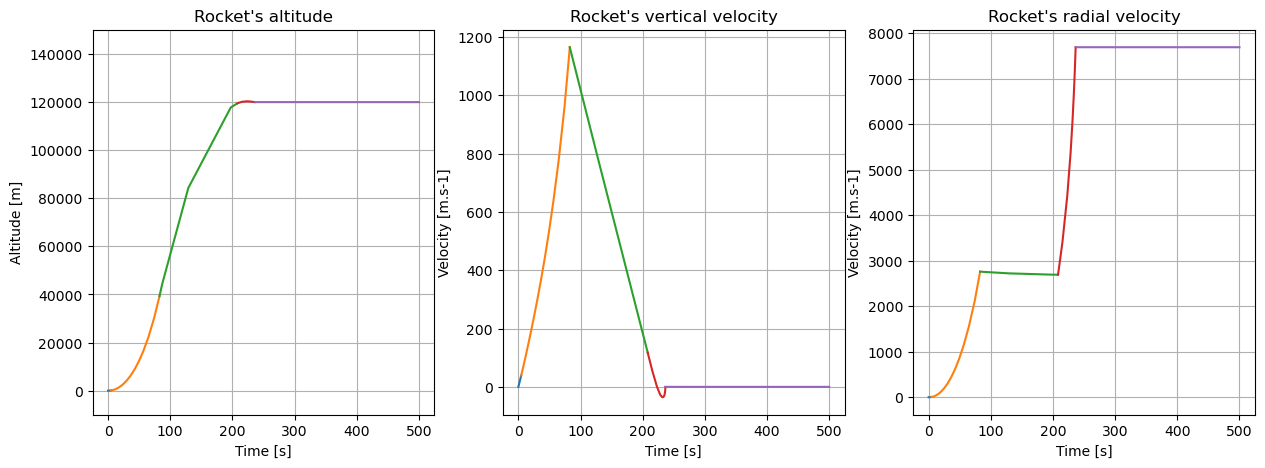

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(131)
for s in sol:
    plt.plot(s.t, s.y[0]-earth.R)
plt.grid()
plt.ylim(-10e3, 150e3)
plt.title("Rocket's altitude")
plt.xlabel('Time [s]')
plt.ylabel('Altitude [m]')

plt.subplot(132)
for s in sol:
    plt.plot(s.t, s.y[2])
plt.grid()
plt.title("Rocket's vertical velocity")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m.s-1]')

plt.subplot(133)
for s in sol:
    plt.plot(s.t, earth.R*s.y[3])
plt.title("Rocket's radial velocity")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m.s-1]')
plt.grid()

Text(0, 0.5, 'Altitude [m]')

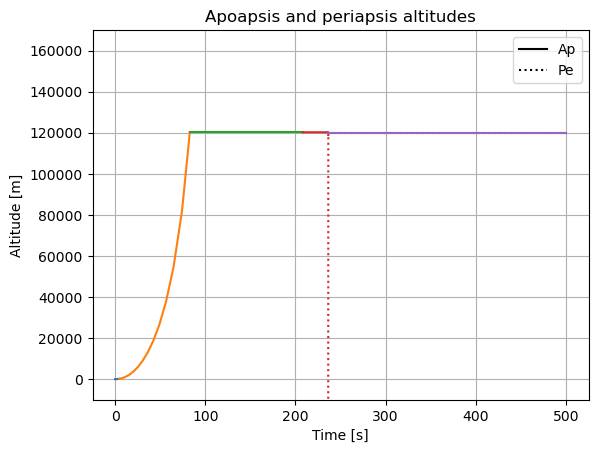

In [53]:
plt.figure()
for s in sol:
    line, = plt.plot(s.t, [r_a(y, earth)-earth.R for y in s.y.T])
    plt.plot(s.t, [r_p(y, earth)-earth.R for y in s.y.T], ':', c=line.get_color())
plt.plot([],[],'k', label='Ap')
plt.plot([],[],'k:', label='Pe')
plt.ylim(-10e3,170e3)
plt.grid()
plt.legend()
plt.title('Apoapsis and periapsis altitudes')
plt.xlabel('Time [s]')
plt.ylabel('Altitude [m]')